In [1]:
import numpy as np
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib import pyplot as plt

from openfisca_survey_manager.utils import asof

from openfisca_france_indirect_taxation import FranceIndirectTaxationTaxBenefitSystem
from openfisca_france_indirect_taxation.examples.utils_example import (
    wavg,
    collapse,
    dataframe_by_group,
    graph_builder_bar)
from openfisca_france_indirect_taxation.surveys import SurveyScenario
from openfisca_france_indirect_taxation.calibration import get_inflators_by_year_energy

from openfisca_france_indirect_taxation.projects.Master_Thesis_Herve.Reform_carbon_tax import carbon_tax_rv
from openfisca_france_indirect_taxation.projects.Master_Thesis_Herve.Simulation_taxe_energie_winners_losers import (
    simulate_reformes_energie,
    run_all_elasticities,
    graph_winners_losers,
    graph_net_transfers,
    graph_effort_rate
    )

In [2]:
ident_men = pd.DataFrame(pd.HDFStore("C:/Users/veve1/OneDrive/Documents/ENSAE 3A/Memoire MiE/Data/data_collections/output/openfisca_indirect_taxation_data_2017.h5")['input']['ident_men'])
ident_men['ident_men'] = ident_men.ident_men.astype(numpy.int64)

data_path = "C:/Users/veve1/OneDrive/Documents/ENSAE 3A/Memoire MiE/Data"
output_path = os.path.join(data_path,'donnees_simulations')
elasticite = True
replique_gouv = True

In [52]:
# To create a dataframe with elasticities from Douenne (2020)
table_data = {
    'niveau_vie_decile': ['Rural', 'Small cities', 'Medium cities', 'Large cities', 'Paris'],
    1.0: [(-0.54,-0.43), (-0.55,-0.39), (-0.58,-0.37), (-0.55,-0.21), (-0.49,-0.01)],
    2.0: [(-0.54,-0.43), (-0.54,-0.37), (-0.56,-0.34), (-0.54,-0.21), (-0.45,-0.01)],
    3.0: [(-0.52,-0.39), (-0.53,-0.35), (-0.56,-0.32), (-0.51,-0.16), (-0.47,0.07)],
    4.0: [(-0.52,-0.37), (-0.51,-0.34), (-0.53,-0.29), (-0.50,-0.13), (-0.44,0.04)],
    5.0: [(-0.51,-0.35), (-0.50,-0.33), (-0.54,-0.28), (-0.47,-0.10), (-0.42,0.06)],
    6.0: [(-0.49,-0.32), (-0.50,-0.29), (-0.51,-0.26), (-0.47,-0.08), (-0.36,0.14)],
    7.0: [(-0.48,-0.29), (-0.46,-0.25), (-0.48,-0.23), (-0.44,-0.04), (-0.41,0.14)],
    8.0: [(-0.45,-0.27), (-0.44,-0.22), (-0.46,-0.23), (-0.42,-0.02), (-0.34,0.22)],
    9.0: [(-0.45,-0.26), (-0.42,-0.20), (-0.44,-0.19), (-0.36,0.05), (-0.29,0.32)],
    10.0: [(-0.38,-0.28), (-0.37,-0.20), (-0.37,-0.19), (-0.30,0.08), (-0.17,0.38)]
}

df_elas = pd.DataFrame(table_data)
# reshape it a bit
df_elas = df_elas.T
df_elas.reset_index(inplace= True)
df_elas.rename(columns = df_elas.iloc[0],inplace = True)
df_elas.drop(index = 0, axis = 0, inplace = True)
df_elas
# Write the DataFrame to a CSV file
df_elas.to_csv(os.path.join(data_path,'Elasticities_Douenne_20.csv'))


In [80]:
df_elas

,niveau_vie_decile,Rural,Small cities,Medium cities,Large cities,Paris
1,1.0,"(-0.54, -0.43)","(-0.55, -0.39)","(-0.58, -0.37)","(-0.55, -0.21)","(-0.49, -0.01)"
2,2.0,"(-0.54, -0.43)","(-0.54, -0.37)","(-0.56, -0.34)","(-0.54, -0.21)","(-0.45, -0.01)"
3,3.0,"(-0.52, -0.39)","(-0.53, -0.35)","(-0.56, -0.32)","(-0.51, -0.16)","(-0.47, 0.07)"
4,4.0,"(-0.52, -0.37)","(-0.51, -0.34)","(-0.53, -0.29)","(-0.5, -0.13)","(-0.44, 0.04)"
5,5.0,"(-0.51, -0.35)","(-0.5, -0.33)","(-0.54, -0.28)","(-0.47, -0.1)","(-0.42, 0.06)"
6,6.0,"(-0.49, -0.32)","(-0.5, -0.29)","(-0.51, -0.26)","(-0.47, -0.08)","(-0.36, 0.14)"
7,7.0,"(-0.48, -0.29)","(-0.46, -0.25)","(-0.48, -0.23)","(-0.44, -0.04)","(-0.41, 0.14)"
8,8.0,"(-0.45, -0.27)","(-0.44, -0.22)","(-0.46, -0.23)","(-0.42, -0.02)","(-0.34, 0.22)"
9,9.0,"(-0.45, -0.26)","(-0.42, -0.2)","(-0.44, -0.19)","(-0.36, 0.05)","(-0.29, 0.32)"
10,10.0,"(-0.38, -0.28)","(-0.37, -0.2)","(-0.37, -0.19)","(-0.3, 0.08)","(-0.17, 0.38)"


In [96]:
dict_elas = df_elas.set_index('niveau_vie_decile').to_dict('index')
dict_elas

{1.0: {'Rural': (-0.54, -0.43),
  'Small cities': (-0.55, -0.39),
  'Medium cities': (-0.58, -0.37),
  'Large cities': (-0.55, -0.21),
  'Paris': (-0.49, -0.01)},
 2.0: {'Rural': (-0.54, -0.43),
  'Small cities': (-0.54, -0.37),
  'Medium cities': (-0.56, -0.34),
  'Large cities': (-0.54, -0.21),
  'Paris': (-0.45, -0.01)},
 3.0: {'Rural': (-0.52, -0.39),
  'Small cities': (-0.53, -0.35),
  'Medium cities': (-0.56, -0.32),
  'Large cities': (-0.51, -0.16),
  'Paris': (-0.47, 0.07)},
 4.0: {'Rural': (-0.52, -0.37),
  'Small cities': (-0.51, -0.34),
  'Medium cities': (-0.53, -0.29),
  'Large cities': (-0.5, -0.13),
  'Paris': (-0.44, 0.04)},
 5.0: {'Rural': (-0.51, -0.35),
  'Small cities': (-0.5, -0.33),
  'Medium cities': (-0.54, -0.28),
  'Large cities': (-0.47, -0.1),
  'Paris': (-0.42, 0.06)},
 6.0: {'Rural': (-0.49, -0.32),
  'Small cities': (-0.5, -0.29),
  'Medium cities': (-0.51, -0.26),
  'Large cities': (-0.47, -0.08),
  'Paris': (-0.36, 0.14)},
 7.0: {'Rural': (-0.48, -0.29)

In [77]:
from openfisca_france_indirect_taxation.almost_ideal_demand_system.utils import (
    add_niveau_vie_decile
)

In [120]:
ident_men_2 = pd.HDFStore("C:/Users/veve1/OneDrive/Documents/ENSAE 3A/Memoire MiE/Data/data_collections/output/openfisca_indirect_taxation_data_2017.h5")['input'][['ident_men','pondmen', 'rev_disponible','ocde10','strate']]
ident_men_2 = add_niveau_vie_decile(ident_men_2)

In [121]:
dict_strate = { 0 : 'Rural' , 1 : 'Small cities' , 2 : 'Medium cities' , 3 : 'Large cities' , 4 : 'Paris'}

In [122]:
ident_men_2['strate_2'] = ident_men_2['strate'].apply(lambda x : dict_strate.get(x))

In [118]:
ident_men_2['step_1'] = ident_men_2['niveau_vie_decile'].apply(lambda x : dict_elas.get(x))

In [ ]:
def get_elas(a,b):
    elas = dict_elas.get(a).get

In [124]:
ident_men_2

,ident_men,pondmen,rev_disponible,ocde10,strate,niveau_vie_decile,strate_2,elas_price_1_1
9260,6409,4467.331955,0.0,1.0,3,1.0,Large cities,"(-0.54, -0.43)"
8013,4851,3175.427259,-0.0,1.0,4,1.0,Paris,"(-0.54, -0.43)"
501,10639,6455.34054,-0.0,1.0,2,1.0,Medium cities,"(-0.54, -0.43)"
3810,14853,1744.92422,-0.0,1.5,0,1.0,Rural,"(-0.54, -0.43)"
1292,1164,2632.337133,-0.0,1.0,3,1.0,Large cities,"(-0.54, -0.43)"
...,...,...,...,...,...,...,...,...
3323,14228,2270.084999,305334.538115,1.5,4,10.0,Paris,"(-0.38, -0.28)"
4804,16092,3507.215877,385822.945336,1.5,4,10.0,Paris,"(-0.38, -0.28)"
4954,16268,2230.388625,388091.267664,1.5,4,10.0,Paris,"(-0.38, -0.28)"
10844,8423,1910.688729,705428.75,2.5,3,10.0,Large cities,"(-0.38, -0.28)"


In [3]:
df_elasticities = pd.read_csv(os.path.join(data_path,'Elasticities_literature.csv'), sep = ";")
df_elasticities = df_elasticities.astype({'ref_elasticity': str, 'elas_price_1_1': float , 'elas_price_2_2' : float ,'elas_price_3_3' : float })

# exemple
#elasticites = df_elasticities[df_elasticities['ref_elasticity'] == 'Douenne (2020)'] 

In [4]:
to_graph, menages_reform = run_all_elasticities(df_elasticities, year = 2019, reform = carbon_tax_rv)

In [5]:
menages_reform

,ticpe_totale_carbon_tax_rv,ticpe_totale,pondmen,rev_disp_loyerimput,ocde10,contributions_reforme,niveau_vie_decile,ref_elasticity,bonus_cheques_energie,Net_transfers_reform,Effort_rate,Is_losers
0,1294.521606,1259.019531,1443,42128.300781,1.5,35.502075,7.0,Combet et al (2009),23.148266,-12.353809,0.084271,True
1,742.048340,721.697754,2407,20616.986328,1.0,20.350586,3.0,Combet et al (2009),15.432177,-4.918409,0.098708,True
2,498.453644,484.783630,968,37976.449219,2.6,13.670013,2.0,Combet et al (2009),40.123657,26.453644,0.035996,False
3,396.820068,385.371582,2076,38973.976562,1.5,11.448486,3.0,Combet et al (2009),23.148266,11.699780,0.029375,False
4,1192.532349,1159.827393,1364,45748.765625,2.0,32.704956,6.0,Combet et al (2009),30.864353,-1.840603,0.071488,True
...,...,...,...,...,...,...,...,...,...,...,...,...
12076,1096.395508,1040.114990,3702,62270.660156,2.1,56.280518,7.0,Douenne (2020),33.671379,-22.609138,0.090380,True
12077,0.000000,0.000000,1743,49516.070312,1.5,0.000000,7.0,Douenne (2020),24.050987,24.050987,0.000000,False
12078,0.000000,0.000000,1571,53809.738281,1.5,0.000000,8.0,Douenne (2020),24.050987,24.050987,0.000000,False
12079,0.000000,0.000000,1087,14518.916992,1.0,0.000000,2.0,Douenne (2020),16.033991,16.033991,0.000000,False


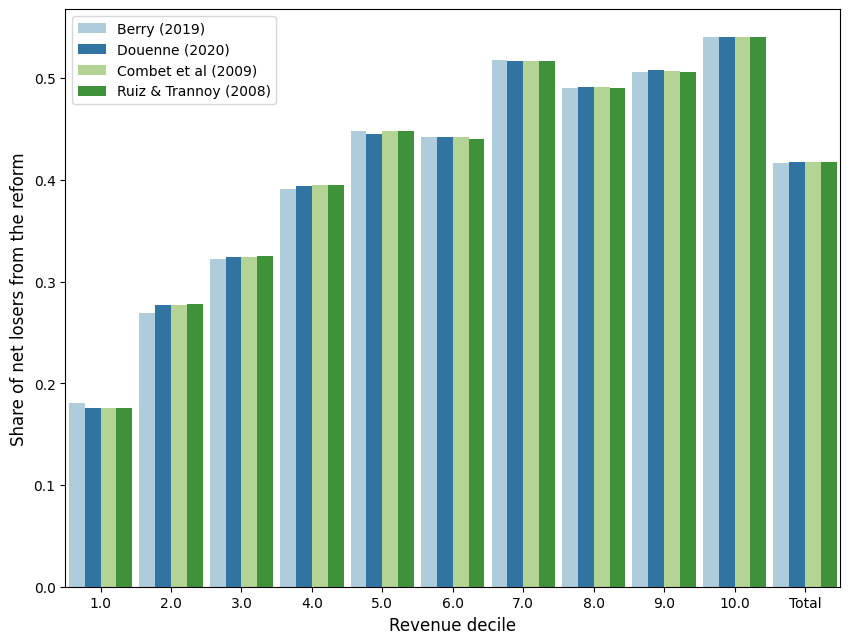

In [6]:
graph_winners_losers(to_graph,carbon_tax_rv)

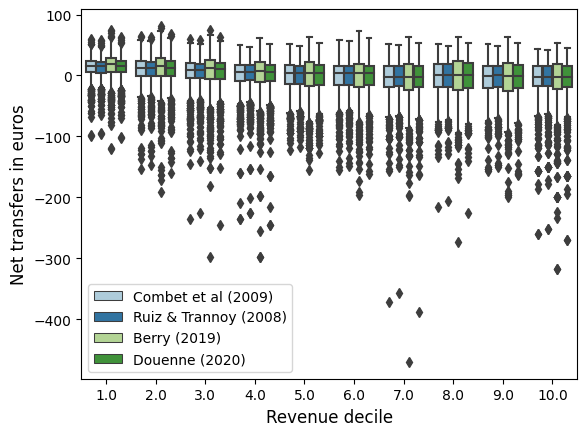

In [12]:
#graph pas pondéré
sns.boxplot(data = menages_reform, x = "niveau_vie_decile", y = "Net_transfers_reform", hue = "ref_elasticity", palette = sns.color_palette("Paired"))
plt.xlabel('Revenue decile', fontdict = {'fontsize' : 12})
plt.ylabel('Net transfers in euros', fontdict = {'fontsize' : 12})
plt.legend()

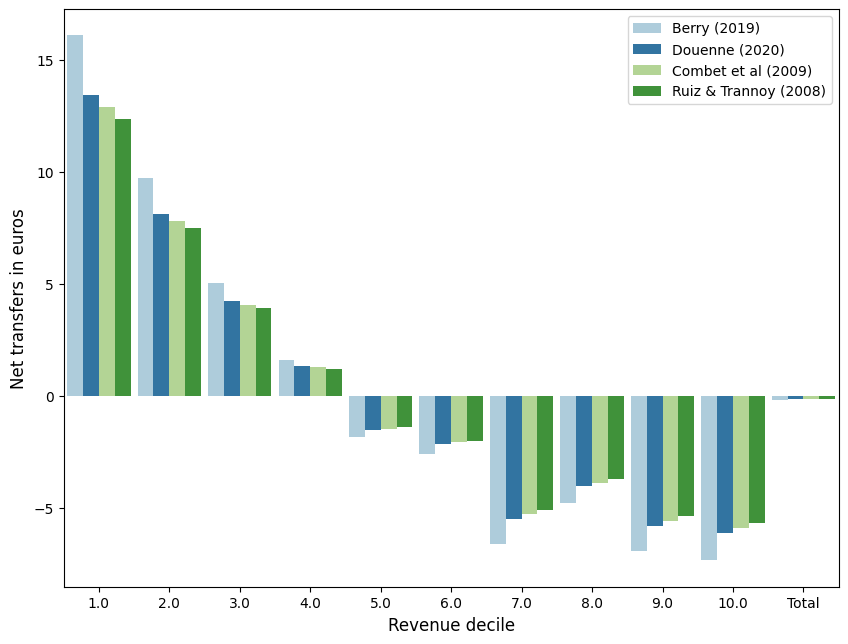

In [8]:
graph_net_transfers(to_graph,carbon_tax_rv)

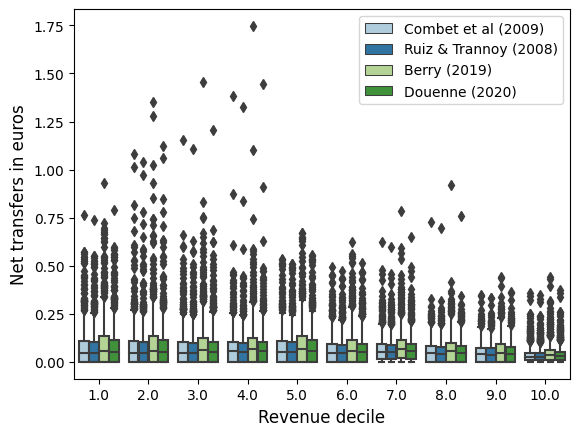

In [13]:
sns.boxplot(data = menages_reform, x = "niveau_vie_decile", y = "Effort_rate", hue = "ref_elasticity", palette = sns.color_palette("Paired"))
plt.xlabel('Revenue decile', fontdict = {'fontsize' : 12})
plt.ylabel('Additional taxes over disposable income', fontdict = {'fontsize' : 12})
plt.legend()

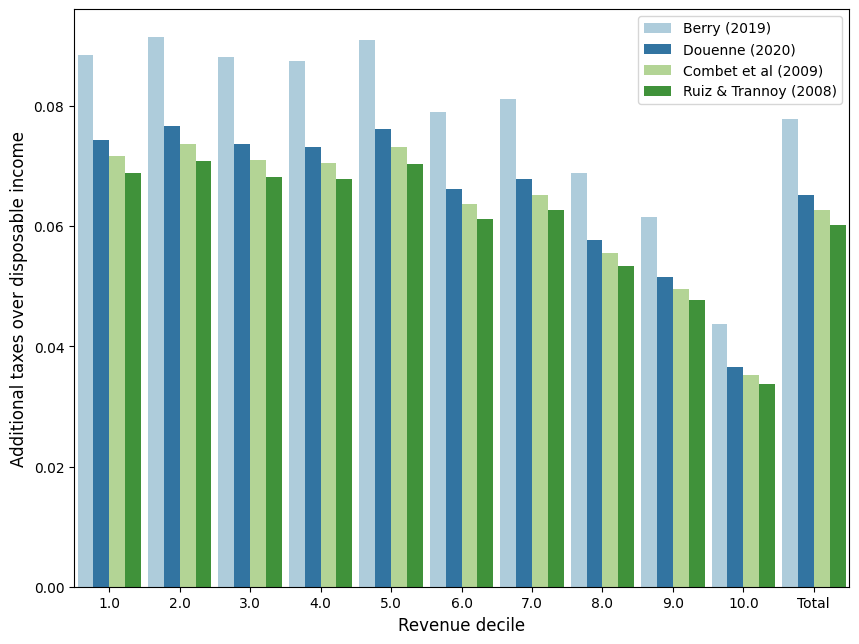

In [11]:
graph_effort_rate(to_graph,carbon_tax_rv)

In [53]:
df_elas.loc[3,'Rural']

(-0.52, -0.39)